# Image Compression using FFT

According to the fourier transformation every waves can be converted into sine or cosine waves. Fourier transformation is carried out to ease the process of wave analysis. But fourier transformation only works effectively on continuous wave signal. For carying fourier transformation in discrete wave signals. Discrete Fourier Transformation (DFT) should be carried out. DFT is done by calculating the area below the sine wave for n numbers of sine wave for every signal frequency. Time complexity of O(n<sup>2</sup>)

But talking about the periodic waves they are sum of odd and even function. So, f(x) = f(-x) and f(x) = -f(x). Therefore, the DFT can be carried by only operating for half the time it should be.The given solution is called Fast Fourier Transformation. Time complexity of O(nlog<sub>2</sub>n) 

For carring out FFT, **Cooley-Tukey algorithm** is the most used algorithm.

In this project, we would be using Cooley-Tukey algorith to find the fourier transform of image(i.e. discrete wave signal). And discard all the small fourier signals having small amplitude to compress the image.

## Importing all the important Libararies

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
from numba import njit

## Importing Image from url and changing it into np array

In [2]:
response = requests.get(r"https://img.freepik.com/free-photo/portrait-white-man-isolated_53876-40306.jpg?w=2000")
image = Image.open(BytesIO(response.content))
imageArray = array(image)

In [3]:
# image = Image.open("Screenshot from 2022-09-26 00-15-11.png")
# imageArray = array(image)

# imageArray = imageArray[:, :, :3]

In [4]:
(x,y,_) = imageArray.shape
imageArray.shape

(1556, 2000, 3)

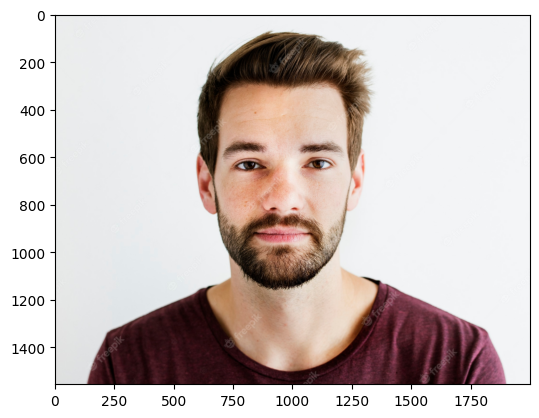

In [5]:
plt.imshow(imageArray)

## As the mathmatics for FFT of problem having number of samples not equal to 2<sup>n</sup> is complex. Also, Cooley-Tukey algorithm only gives the solution for problem having number of samples 2<sup>n</sup>. So, changing the given image array into 2<sup>n</sup> samples by adding null values

In [6]:
def correction(var):
    return int(math.pow(2,math.ceil(math.log2(var))))-var

crtImgArr = np.zeros(((x+correction(x)),(y+correction(y)),3),dtype=int)

for i in range((x+correction(x))):
    if(not((i<math.ceil(correction(x)/2))or(i>x+math.floor(correction(x)/2)-1))):
        crtImgArr[i,math.ceil(correction(y)/2):math.ceil(y+(correction(y)/2))]=imageArray[i-math.ceil(correction(x)/2)]

Size of image is now:  (2048, 2048, 3)


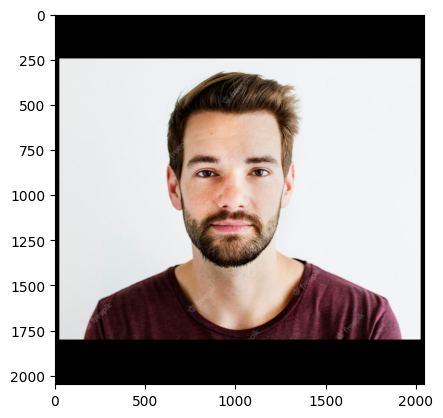

In [7]:
print("Size of image is now: ",crtImgArr.shape)
plt.imshow(crtImgArr)

## As the give image was reprensented into 3d array where third axi carring RGB value in list. Converting the given array into 2d for transformation

In [8]:
@njit()
def rgb_to_gray(img: np.ndarray, dtype) -> np.ndarray:
    """Converts 3 channel RGB to 1 channel Grayscale"""

    grayScale = np.zeros((img.shape[0], img.shape[1]),dtype=dtype)

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            grayScale[i,j] = (np.average(img[i,j,:]))

    return grayScale


grayScale = rgb_to_gray(crtImgArr, dtype=crtImgArr.dtype)


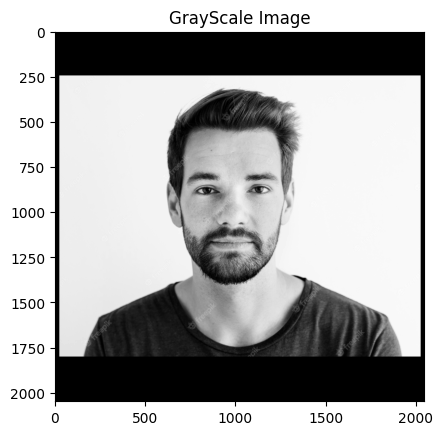

In [9]:
plt.title("GrayScale Image")
plt.imshow(grayScale,cmap="gray")

In [10]:
print(grayScale.shape)

(2048, 2048)


## FFT Algorithm

In [11]:
@njit()
def cooley_tukey_fft(x: np.ndarray) -> np.ndarray:
    n = len(x)

    if n == 1:
        return np.asarray(x, dtype=np.complex128)

    # Split the input sequence into even and odd-indexed sub-sequences
    x_even = x[::2]
    x_odd = x[1::2]

    # Recursively compute the FFT of each sub-sequence
    y_even = cooley_tukey_fft(x_even)
    y_odd = cooley_tukey_fft(x_odd)

    # Combine the results
    y = np.zeros(n, dtype=np.complex128)
    for k in range(n//2):
        y_even_k = y_even[k]
        y_odd_k = y_odd[k]
        twiddle_factor = np.exp(-2j * np.pi * k / n)
        y[k] = y_even_k + twiddle_factor * y_odd_k
        y[k + n//2] = y_even_k - twiddle_factor * y_odd_k

    return y

@njit()
def custom_fft2(img, height, width, dtype, axis):
    """
    if axis = 0, row is ffted, if axis = 1, column is ffted
    """
    _range = width if not axis else height

    trans = np.zeros((height,width),dtype=dtype)
    for i in range(_range):
        if axis==1:
            trans[:, i] = cooley_tukey_fft(img[:,i])
        else:
            trans[i, :] = cooley_tukey_fft(img[i,:])

    return trans

In [12]:
transX = custom_fft2(grayScale, grayScale.shape[0], grayScale.shape[1], np.complex128, axis=0)


## The given result from fft is complex value so ploting only taking the angle or magnitude only

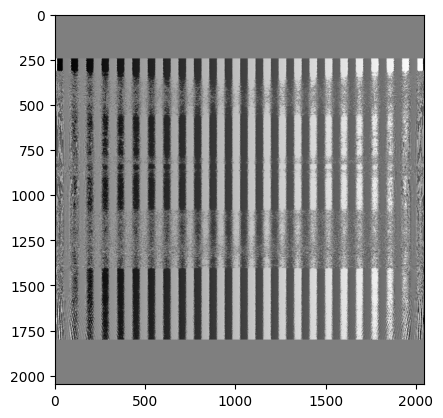

In [13]:
plt.imshow(np.angle(transX),cmap='gray')

In [14]:
transY = custom_fft2(transX, transX.shape[0], transX.shape[1], np.complex128, axis=1)


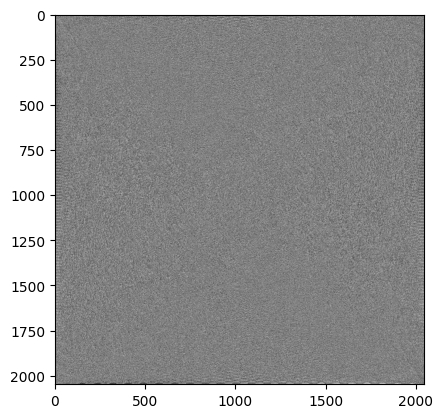

In [15]:
plt.imshow(np.angle(transY),cmap="gray")

# Inverse FFT

In [16]:
@njit()
def cooley_tukey_ifft(x: np.ndarray) -> np.ndarray:
    n = len(x)

    if n == 1:
        return np.asarray(x, dtype=np.complex128)

    # Split the input sequence into even and odd-indexed sub-sequences
    x_even = x[::2]
    x_odd = x[1::2]

    # Recursively compute the IFFT of each sub-sequence
    y_even = cooley_tukey_ifft(x_even)
    y_odd = cooley_tukey_ifft(x_odd)

    # Combine the results
    y = np.zeros(n, dtype=np.complex128)
    for k in range(n//2):
        y_even_k = y_even[k]
        y_odd_k = y_odd[k]
        twiddle_factor = np.exp(2j * np.pi * k / n)
        y[k] = y_even_k + twiddle_factor * y_odd_k
        y[k + n//2] = y_even_k - twiddle_factor * y_odd_k

    return y/n

@njit()
def custom_ifft2(img, height, width, dtype, axis):
    """row: axis = 0, column: axis = 1"""
    _range = width if not axis else height

    itrans = np.zeros((height,width),dtype=dtype)
    for i in range(_range):
        if axis==1:
            itrans[:, i] = cooley_tukey_ifft(img[:,i])
        else:
            itrans[i, :] = cooley_tukey_ifft(img[i,:])

    return itrans

In [17]:
invY = custom_ifft2(transY, transY.shape[0], transY.shape[1], dtype=np.complex128, axis=0)

In [18]:
img = custom_ifft2(invY, invY.shape[0], invY.shape[1], dtype=np.complex128, axis=1)

In [19]:
img = img / np.max(img) * 255


In [20]:
img = img.astype(np.uint8)

/tmp/ipykernel_8282/2433346074.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  img = img.astype(np.uint8)


In [21]:
img_abs = np.abs(img)

In [22]:
img_norm = img_abs / img_abs.max()


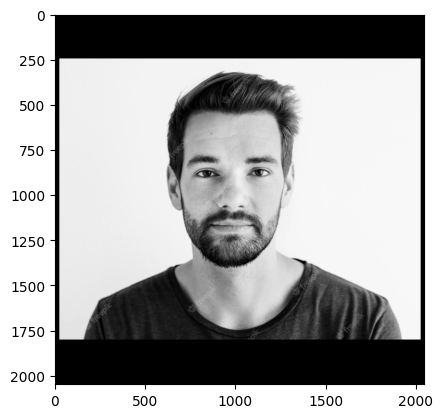

In [23]:
plt.imshow(img_norm, cmap='gray')


